# __“Snapshot & Gaps” (istantanea + buchi di policy) + “Adozione nel tempo” (storia 2007→2022)__ #

1. Mappa “Indice O” (0–9), ultimo anno
- Titolo-verdetto: “Offerta di aiuto diseguale: Europa in testa, Africa in coda.”
- Inquadra il mondo con callout su 3 top e 3 bottom.

2. Infografica “componenti → Indice O” (stile poster che ti piace)
- Titolo: “Coperture parziali frenano l’indice O: ‘most’ ancora minoranza in molti setting.”
- Mostra dove sono i buchi (tratteggi) e come pesano nel totale.

3. Trend per regione OMS: Quitline (%) e Primary care ‘Yes in most’ (%) (Due pannelli affiancati o due figure coerenti con P)
- Titolo: “Adozione in crescita, ma ‘copertura piena’ avanza lentamente fuori da Europa/Am. ”
- Ricalca i tuoi grafici di P: linee pulite, etichette finali on-line, nota sul denominatore.

4. Scatter “Servizi vs Farmaci”, punti = Paesi (ultimo anno)
- Titolo: “Ecosistema incompleto: dove i servizi non incontrano i farmaci (e viceversa).”
- Colori per regione, annota 3–4 outlier; è il tuo grafico “relazione” conclusivo (coerente con M&P).

## __1. Mappa “Indice O” (0–9), ultimo anno__

In [7]:
# =========================
# O1 — Mappa "Indice O" (0–9), ultimo dato ≤ 2022
# =========================
from pathlib import Path
import re, numpy as np, pandas as pd
import plotly.express as px

# --- PATHS (coerenti con la tua repo)
PROJ = Path.cwd()
DATA_DIRS = [
    PROJ / "data" / "O",
    PROJ / "data",
    PROJ,                            # fallback: stessa cartella del notebook
]
OUT_DIR = PROJ / "lavoro marco" / "O" / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FILES = {
    "quitline": "Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv",
    "primary_care": "Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv",
    "hospitals": "Tobacco_help_smoking_cessation_support_is_available_in_hospitals.csv",
    "community": "Tobacco_help_smoking_cessation_support_is_available_in_the_community.csv",
    "other_settings": "Tobacco_help_smoking_cessation_support_is_available_in_other_settings.csv",
    "nrt": "Tobacco_medication_legally_sold_nicotine_replacement_therapy.csv",
    "bupropion": "Tobacco_medication_legally_sold_Bupropion.csv",
    "varenicline": "Varenicline_-_legally_sold_(Tobacco_control_Offer_help).csv",
    "cytisine": "Tobacco_medication_legally_sold_Cytisine.csv",
}

# tipo componente: servizi (3 stati) vs binario
COMP_KIND = {
    "quitline": "binary",
    "primary_care": "service",
    "hospitals": "service",
    "community": "service",
    "other_settings": "service",
    "nrt": "binary",
    "bupropion": "binary",
    "varenicline": "binary",
    "cytisine": "binary",
}

# -------- Helpers
def find_file(fname: str) -> Path:
    for d in DATA_DIRS:
        p = d / fname
        if p.exists():
            return p
    # ultimo tentativo: cerca ricorsivo
    hits = list(PROJ.rglob(fname))
    if hits:
        return hits[0]
    raise FileNotFoundError(fname)

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    cl = {c.lower(): c for c in df.columns}
    def pick(*cands):
        for c in cands:
            if c in cl: return cl[c]
            for k,v in cl.items():
                if c in k: return v
        return None
    ren = {}
    iso = pick("spatialdimvaluecode","iso3","code","country_code")
    if iso: ren[iso] = "iso3"
    country = pick("location","country","spatialdim","name")
    if country: ren[country] = "country"
    region = pick("parentlocation","who_region","region")
    if region: ren[region] = "region"
    year = pick("timedim","year","period","time")
    if year: ren[year] = "year"
    value = pick("value","displayvalue","numericvalue","factvaluenumeric")
    if value: ren[value] = "value_raw"
    df = df.rename(columns=ren)
    keep = [c for c in ["iso3","country","region","year","value_raw"] if c in df.columns]
    return df[keep].copy()

def normalize_value_to_score(s: pd.Series, kind: str) -> pd.Series:
    def map_one(x):
        if pd.isna(x): return np.nan
        t = re.sub(r"[^a-z\s]", " ", str(x).lower()).strip()
        t = re.sub(r"\s+", " ", t)
        if kind == "service":
            if "most" in t: return 1.0
            if "some" in t or "partial" in t: return 0.5
            if t == "yes" or "available" in t: return 1.0
            if "no" in t or "not" in t or "none" in t: return 0.0
            return np.nan
        else:  # binary
            if t.startswith("yes") or "available" in t or "legally sold" in t: return 1.0
            if t.startswith("no") or "not" in t or "none" in t: return 0.0
            return np.nan
    return s.map(map_one)

def load_component(name: str, path: Path, kind: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = standardize_columns(df)
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
        df = df[df["year"] <= 2022]
    df["score"] = normalize_value_to_score(df["value_raw"], kind)
    # ultimo anno per paese
    if "year" in df.columns:
        idx = df.groupby("iso3")["year"].transform("max") == df["year"]
        df = df[idx].sort_values(["iso3","score"]).drop_duplicates("iso3", keep="last")
    else:
        df = df.drop_duplicates("iso3", keep="last")
        df["year"] = pd.NA
    return df.rename(columns={"score": f"{name}_score", "year": f"{name}_year"})

# -------- Carica componenti (con country/region) --------
parts = []
for comp, fname in FILES.items():
    d = load_component(comp, find_file(fname), COMP_KIND[comp])
    parts.append(d)

# -------- Meta lookup: iso3 -> country, region (una volta sola) --------
meta = pd.concat([p[["iso3","country","region"]] for p in parts], ignore_index=True)
meta["iso3"] = meta["iso3"].str.upper()
meta = (
    meta.groupby("iso3", as_index=False)
        .agg({
            "country": lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan,
            "region":  lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan
        })
)

# -------- Tabelle dei punteggi (senza country/region per evitare suffix) --------
score_frames = []
for comp, p in zip(FILES.keys(), parts):
    f = p[["iso3", f"{comp}_year", f"{comp}_score"]].copy()
    score_frames.append(f)

from functools import reduce
df_scores = reduce(lambda L, R: pd.merge(L, R, on="iso3", how="outer"), score_frames)

# -------- Merge finale con meta --------
df = df_scores.merge(meta, on="iso3", how="left")


# ricomponi country/region
for c in [c for c in df.columns if c.endswith("country")]:
    if "country" not in df: df["country"] = np.nan
    df["country"] = df["country"].fillna(df[c])
for c in [c for c in df.columns if c.endswith("region")]:
    if "region" not in df: df["region"] = np.nan
    df["region"] = df["region"].fillna(df[c])

score_cols = [c for c in df.columns if c.endswith("_score")]
year_cols  = [c for c in df.columns if c.endswith("_year")]

df["available_n"] = df[score_cols].notna().sum(axis=1)
df["sum_scores"]  = df[score_cols].sum(axis=1, skipna=True)
df["O_index_raw"] = df["sum_scores"]                        # mancanti=0 implicito
df["O_index_norm"] = (df["sum_scores"] / df["available_n"]).clip(0,1) * len(score_cols)
df.loc[df["available_n"]==0, "O_index_norm"] = np.nan
df["latest_year_max"] = df[year_cols].apply(pd.to_numeric, errors="coerce").max(axis=1)

# salva tabella per callout
cols_out = ["iso3","country","region","latest_year_max","available_n","O_index_raw","O_index_norm"] + score_cols
df.sort_values("O_index_norm", ascending=False).to_csv(OUT_DIR / "O_index_latest_by_country.csv", index=False)

# -------- Mappa con Plotly (range 0–9)
fig = px.choropleth(
    df, locations="iso3", color="O_index_norm",
    color_continuous_scale="Blues", range_color=(0,9),
    hover_name="country",
    hover_data={c:":.2f" for c in ["O_index_norm","O_index_raw"]},
    title="Offer index (0–9) — Offer of help to quit smoking (2022)",
    labels={"O_index_norm":"Indice O (0–9)"}
)
fig.update_layout(
    margin=dict(l=0, r=0, t=60, b=10),
    title_x=0.5,
    coloraxis_colorbar=dict(
        title="Offer index",
        x=0.83,           # subito dentro al bordo destro del plot
        xanchor="left",    
        y=0.5,
        len=0.75,
        thickness=18
    )
)




fig.show()
# Salvataggi
html_path = OUT_DIR / "O1_map_O_index_latest.html"
png_path  = OUT_DIR / "O1_map_O_index_latest.png"
svg_path  = OUT_DIR / "O1_map_O_index_latest.svg"
fig.write_html(str(html_path))
try:
    import kaleido  # noqa
    fig.write_image(str(png_path), scale=2, width=1400, height=650)
    fig.write_image(str(svg_path), width=1400, height=650)
    print("Salvati HTML, PNG e SVG.")
except Exception as e:
    print("Salvato HTML. Per PNG/SVG serve 'kaleido' (pip install -r requirements.txt).")
    print("Dettaglio:", e)

# opzionale: stampa top/bottom per annotazioni in slide
top = df.nlargest(3, "O_index_norm")[["country","O_index_norm"]]
bot = df.nsmallest(3, "O_index_norm")[["country","O_index_norm"]]
print("TOP 3:\n", top.to_string(index=False))
print("BOTTOM 3:\n", bot.to_string(index=False))


Salvati HTML, PNG e SVG.
TOP 3:
     country  O_index_norm
     Canada           8.0
New Zealand           7.5
     Sweden           7.5
BOTTOM 3:
                  country  O_index_norm
     Antigua and Barbuda           0.0
                   Benin           0.0
Central African Republic           0.0


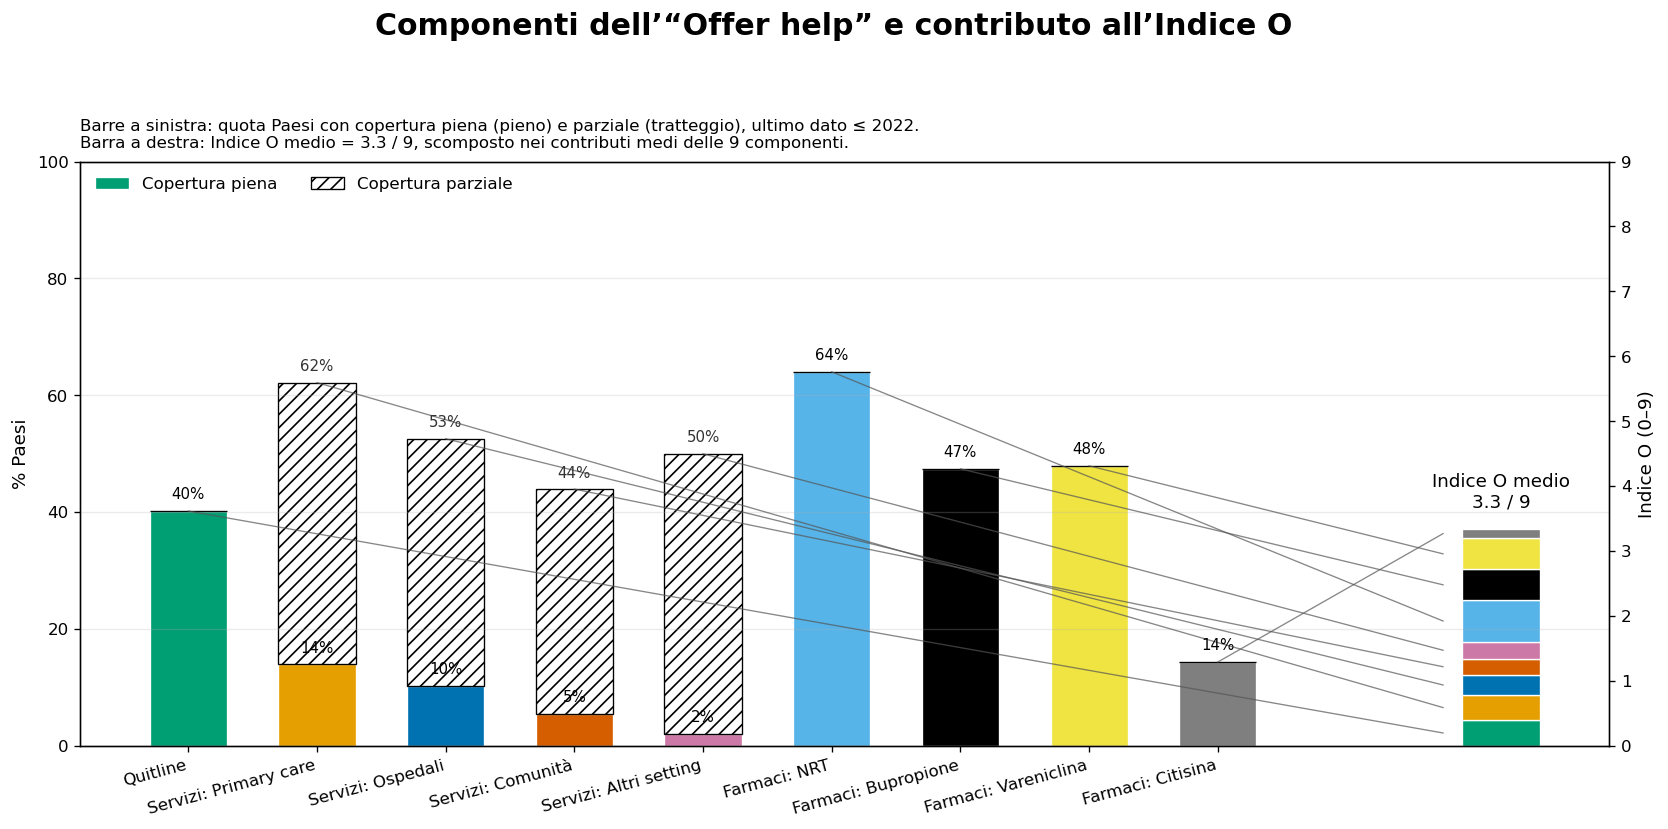

Salvati: c:\Users\cola0\Desktop\scientific-visualization\lavoro marco\lavoro marco\O\outputs\O2_components_to_index.png | c:\Users\cola0\Desktop\scientific-visualization\lavoro marco\lavoro marco\O\outputs\O2_components_to_index.svg


In [ ]:
# =========================
# O2 — Infografica "Componenti → Indice O" (stile poster)
# =========================
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ---- PATH (coerenti con repo)
PROJ = Path.cwd()
DATA_DIRS = [PROJ / "data" / "O", PROJ / "data", PROJ]
OUT_DIR  = PROJ / "lavoro marco" / "O" / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Se non sono già definiti nella cella precedente, ridefiniamo FILES/COMP_KIND/find_file/standardize
try:
    FILES
    COMP_KIND
    find_file
    standardize_columns
except NameError:
    FILES = {
        "quitline": "Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv",
        "primary_care": "Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv",
        "hospitals": "Tobacco_help_smoking_cessation_support_is_available_in_hospitals.csv",
        "community": "Tobacco_help_smoking_cessation_support_is_available_in_the_community.csv",
        "other_settings": "Tobacco_help_smoking_cessation_support_is_available_in_other_settings.csv",
        "nrt": "Tobacco_medication_legally_sold_nicotine_replacement_therapy.csv",
        "bupropion": "Tobacco_medication_legally_sold_Bupropion.csv",
        "varenicline": "Varenicline_-_legally_sold_(Tobacco_control_Offer_help).csv",
        "cytisine": "Tobacco_medication_legally_sold_Cytisine.csv",
    }
    COMP_KIND = {
        "quitline": "binary",
        "primary_care": "service",
        "hospitals": "service",
        "community": "service",
        "other_settings": "service",
        "nrt": "binary",
        "bupropion": "binary",
        "varenicline": "binary",
        "cytisine": "binary",
    }
    def find_file(fname: str) -> Path:
        for d in DATA_DIRS:
            p = d / fname
            if p.exists(): return p
        hits = list(PROJ.rglob(fname))
        if hits: return hits[0]
        raise FileNotFoundError(fname)

    def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
        cl = {c.lower(): c for c in df.columns}
        def pick(*cands):
            for c in cands:
                if c in cl: return cl[c]
                for k,v in cl.items():
                    if c in k: return v
            return None
        ren = {}
        iso = pick("spatialdimvaluecode","iso3","code","country_code")
        if iso: ren[iso] = "iso3"
        country = pick("location","country","spatialdim","name")
        if country: ren[country] = "country"
        region = pick("parentlocation","who_region","region")
        if region: ren[region] = "region"
        year = pick("timedim","year","period","time")
        if year: ren[year] = "year"
        value = pick("value","displayvalue","numericvalue","factvaluenumeric")
        if value: ren[value] = "value_raw"
        df = df.rename(columns=ren)
        keep = [c for c in ["iso3","country","region","year","value_raw"] if c in df.columns]
        return df[keep].copy()

# ---- Parser robusto (prima i negativi!)
def classify_value(x, kind):
    if pd.isna(x): return "na"
    t = re.sub(r"[^a-z\s]", " ", str(x).lower())
    t = re.sub(r"\s+", " ", t).strip()

    # negativi prima
    if re.search(r"\bno\b|\bnot\b|\bnone\b|\bunavailable\b|\bnot available\b|\bnot legally sold\b|\billegal\b|\bprohibited\b|\bunknown\b", t):
        return "no"

    if kind == "service":
        if re.search(r"\bmost\b", t): return "full"      # Yes in most
        if re.search(r"\bsome\b|partial", t): return "partial"
        if re.search(r"\byes\b|available|present", t): return "full"
        return "na"
    else:  # binary
        if re.search(r"\byes\b|available|legally sold", t): return "full"
        return "na"

def score_value(x, kind):
    cls = classify_value(x, kind)
    if cls == "full": return 1.0
    if cls == "partial": return 0.5
    if cls == "no": return 0.0
    return np.nan

def load_component_latest(name, kind, year_max=2022):
    df = pd.read_csv(find_file(FILES[name]))
    df = standardize_columns(df)
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
        df = df[df["year"].notna() & (df["year"] <= year_max)]
        # ultimo anno ≤ year_max per iso3
        if not df.empty:
            idx = df.groupby("iso3")["year"].transform("max") == df["year"]
            df = df[idx]
    df = df.drop_duplicates("iso3", keep="last")
    df["class"] = df["value_raw"].map(lambda v: classify_value(v, kind))
    df["score"] = df["value_raw"].map(lambda v: score_value(v, kind))
    return df[["iso3","country","region","class","score"]].copy()

# ---- Carica tutte le componenti
order_components = [
    ("quitline", "Quitline"),
    ("primary_care", "Servizi: Primary care"),
    ("hospitals", "Servizi: Ospedali"),
    ("community", "Servizi: Comunità"),
    ("other_settings", "Servizi: Altri setting"),
    ("nrt", "Farmaci: NRT"),
    ("bupropion", "Farmaci: Bupropione"),
    ("varenicline", "Farmaci: Vareniclina"),
    ("cytisine", "Farmaci: Citisina"),
]

parts = {key: load_component_latest(key, COMP_KIND[key], year_max=2022) for key,_ in order_components}

# ---- Statistiche per barra singola (piena/parziale)
rows = []
for key, label in order_components:
    d = parts[key]
    total = (d["class"] != "na").sum()
    full  = (d["class"] == "full").sum()
    part  = (d["class"] == "partial").sum()
    pct_full = 100 * full / total if total else np.nan
    pct_part = 100 * part / total if total else np.nan
    mean_score = d["score"].mean(skipna=True)  # 0..1
    rows.append({"key": key, "label": label, "n": total,
                 "pct_full": pct_full, "pct_part": pct_part,
                 "mean_score": mean_score})
summary = pd.DataFrame(rows)

# ---- Contributi per la stacked (indice medio 0..9)
summary["contrib_index_percent"] = summary["mean_score"] * (100/9.0)  # scala per usare asse 0–100 a sinistra
O_index_mean = summary["mean_score"].sum()  # 0..9

# ---- Disegno
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 300,
    "axes.titlesize": 18, "axes.labelsize": 11,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(summary))
bar_width = 0.6

# --- Palette componenti (stile poster, colorblind-safe Okabe–Ito + grigio)
PALETTE_COMPONENT = {
    "quitline":      "#009E73",  # verde (bluish green)
    "primary_care":  "#E69F00",  # arancione
    "hospitals":     "#0072B2",  # blu
    "community":     "#D55E00",  # vermillion (arancio-rosso)
    "other_settings":"#CC79A7",  # viola
    "nrt":           "#56B4E9",  # azzurro
    "bupropion":     "#000000",  # nero profondo (ottimo contrasto)
    "varenicline":   "#F0E442",  # giallo
    "cytisine":      "#7F7F7F",  # grigio (neutro)
}

# usa l'ordine già definito
colors = [PALETTE_COMPONENT[k] for k, _ in order_components]


# 1) Barre componenti: pieno + tratteggio (parziale)
base = ax.bar(x, summary["pct_full"], width=bar_width, color=colors, edgecolor="white", linewidth=0.8, label="Copertura piena")
ax.bar(x, summary["pct_part"], width=bar_width, bottom=summary["pct_full"],
       color="none", edgecolor="black", linewidth=0.8, hatch="///", label="Copertura parziale")

# Etichette percentuali sopra la parte piena (e parziale)
for xi, f, p in zip(x, summary["pct_full"], summary["pct_part"]):
    if not np.isnan(f):
        ax.text(xi, f + 1.5, f"{f:.0f}%", ha="center", va="bottom", fontsize=9)
    if not np.isnan(p) and p > 0:
        ax.text(xi, f + p + 1.5, f"{(f+p):.0f}%", ha="center", va="bottom", fontsize=9, color="#333")

ax.set_xticks(x)
ax.set_xticklabels(summary["label"], rotation=15, ha="right")
ax.set_ylabel("% Paesi")
ax.set_ylim(0, 100)
ax.grid(axis="y", alpha=0.25)

# 2) Stacked "Indice O medio" (riscalata su 0–100 a sinistra, con asse secondario 0–9 a destra)
x_idx = len(summary) + 1.2  # posizione della barra indice
bottom = 0
centers = []  # per connettori
for i, row in summary.iterrows():
    h = row["contrib_index_percent"]  # altezza segmento su scala 0–100
    rect = ax.bar(x_idx, h, width=bar_width, bottom=bottom, color=colors[i], edgecolor="white", linewidth=0.8)
    centers.append(bottom + h/2)
    bottom += h

# Asse secondario 0–9
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_yticks([i*(100/9) for i in range(0,10)])
ax2.set_yticklabels([str(i) for i in range(0,10)])
ax2.set_ylabel("Indice O (0–9)")
ax2.grid(False)

# Titoli e legenda
title = "Componenti dell’“Offer help” e contributo all’Indice O"
subtitle = (f"Barre a sinistra: quota Paesi con copertura piena (pieno) e parziale (tratteggio), ultimo dato ≤ 2022.\n"
            f"Barra a destra: Indice O medio = {O_index_mean:.1f} / 9, scomposto nei contributi medi delle 9 componenti.")
fig.suptitle(title, y=0.98, fontsize=18, fontweight="bold")
ax.set_title(subtitle, fontsize=10, loc="left", pad=8)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncols=2, frameon=False, loc="upper left")

# Etichetta della barra indice
ax.text(x_idx, bottom + 3, f"Indice O medio\n{O_index_mean:.1f} / 9", ha="center", va="bottom", fontsize=11)

# 3) Connettori (componenti → segmento corrispondente)
for i, xi in enumerate(x):
    ax.plot([xi, x_idx - 0.45], [summary.loc[i, "pct_full"] + summary.loc[i, "pct_part"], centers[i]],
            color="#555", linewidth=0.8, alpha=0.7)

# Layout e salvataggi
plt.tight_layout(rect=[0,0,1,0.93])
png = OUT_DIR / "O2_components_to_index.png"
svg = OUT_DIR / "O2_components_to_index.svg"
plt.savefig(png, bbox_inches="tight")
plt.savefig(svg, bbox_inches="tight")
plt.show()

print("Salvati:", png, "|", svg)


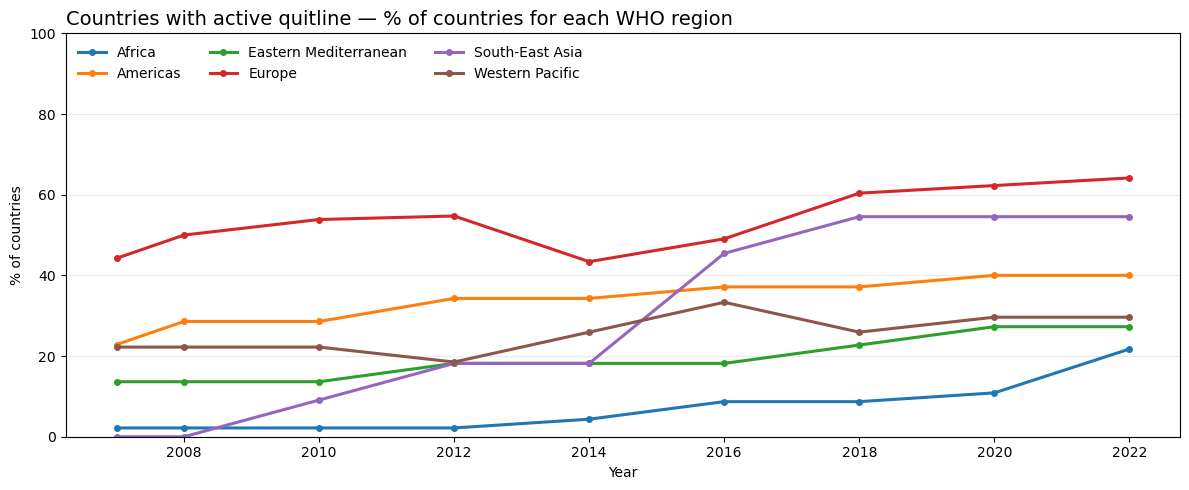

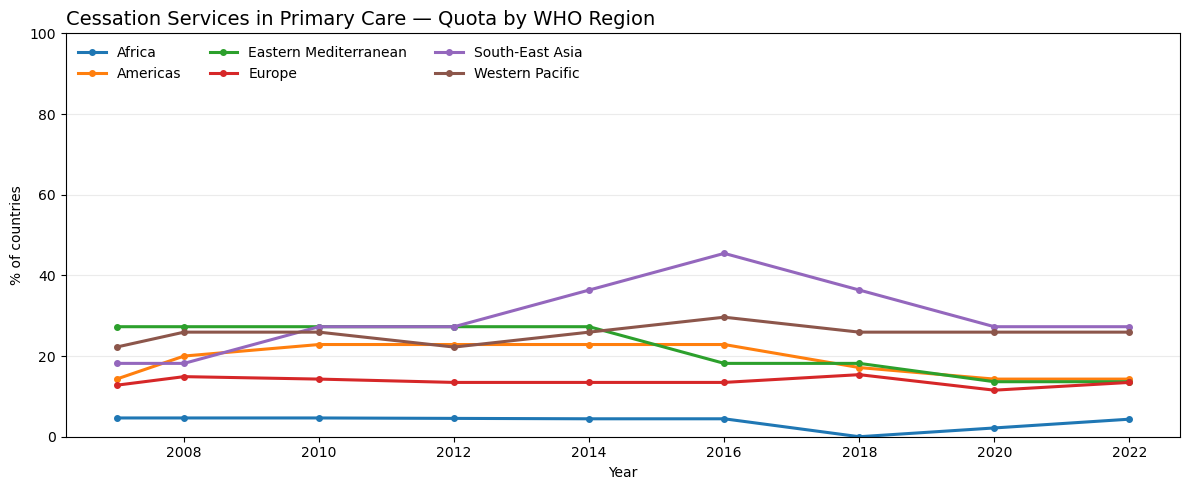

In [9]:
# =========================
# O3 — Trend per Regione OMS
# (a) Quitline attiva (%)   (b) Primary care "Yes in most" (%)
# =========================
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

PROJ = Path.cwd()
DATA_DIRS = [PROJ/"data"/"O", PROJ/"data", PROJ]
OUT_DIR  = PROJ/"lavoro marco"/"O"/"outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FILES = {
    "quitline": "Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv",
    "primary_care": "Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv",
}

def find_file(fname: str) -> Path:
    for d in DATA_DIRS:
        p = d/fname
        if p.exists(): return p
    hits = list(PROJ.rglob(fname))
    if hits: return hits[0]
    raise FileNotFoundError(fname)

REGION_ORDER = ["Africa","Americas","Eastern Mediterranean","Europe","South-East Asia","Western Pacific"]
PALETTE_REGION = {"Africa":"#1f77b4","Americas":"#ff7f0e","Eastern Mediterranean":"#2ca02c",
                  "Europe":"#d62728","South-East Asia":"#9467bd","Western Pacific":"#8c564b"}

def load_ts(csv_path: Path, service: bool, year_min=2007, year_max=2022) -> pd.DataFrame:
    """Estrae serie anno–regione usando direttamente Period/ParentLocation/Value."""
    d = pd.read_csv(csv_path)
    # requisiti minimi
    for c in ["Period","ParentLocation","Value"]:
        if c not in d.columns:
            raise ValueError(f"Nel file {csv_path.name} manca la colonna {c}")
    # anno
    d["year"] = pd.to_numeric(d["Period"].astype(str).str.extract(r"(\d{4})")[0], errors="coerce").astype("Int64")
    d = d[d["year"].between(year_min, year_max, inclusive="both")]
    # classificazione
    def classify(v: str) -> str:
        if pd.isna(v): return "na"
        t = str(v).strip().lower()
        if t in {"missing value", ""}: return "na"
        if t == "no" or " not " in f" {t} " or "unavailable" in t or "illegal" in t: return "no"
        if service:
            if "most" in t or t == "yes": return "full"
            if "some" in t or "partial" in t: return "partial"
        else:
            if "yes" in t or "available" in t or "legally" in t: return "full"
        return "na"
    d["class"]  = d["Value"].map(classify)
    d["region"] = d["ParentLocation"]

    # aggrega anno–regione
    g = (d.groupby(["year","region"])
           .agg(n=("class", lambda s: (s!="na").sum()),
                full=("class", lambda s: (s=="full").sum()))
           .reset_index())
    g["pct_full"] = np.where(g["n"]>0, 100*g["full"]/g["n"], np.nan)
    # tieni solo le 6 regioni OMS canoniche nell'ordine desiderato
    g = g[g["region"].isin(REGION_ORDER)]
    return g

def plot_trend(df_ts: pd.DataFrame, title: str, outfile: Path):
    if df_ts.empty:
        print("⚠️ Nessun dato per:", title)
        display(df_ts.head())
        return
    years = sorted(df_ts["year"].dropna().unique().tolist())
    fig, ax = plt.subplots(figsize=(12,5))
    for reg in REGION_ORDER:
        y = (df_ts[df_ts["region"]==reg]
             .set_index("year")["pct_full"]
             .reindex(years))
        ax.plot(years, y, marker="o", linewidth=2.2, markersize=4,
                label=reg, color=PALETTE_REGION[reg])
    ax.set_ylim(0,100)
    ax.set_ylabel("% of countries")
    ax.set_xlabel("Year")
    ax.grid(True, axis="y", alpha=0.25)
    ax.set_title(title, loc="left", fontsize=14, pad=6)
    ax.legend(ncol=3, frameon=False, loc="upper left")
    plt.tight_layout()
    fig.savefig(outfile.with_suffix(".png"), dpi=300, bbox_inches="tight")
    fig.savefig(outfile.with_suffix(".svg"), dpi=300, bbox_inches="tight")
    plt.show()

# --- (a) Quitline attiva (%)
ts_quit = load_ts(find_file(FILES["quitline"]), service=False)
plot_trend(ts_quit,
           "Countries with active quitline — % of countries for each WHO region",
           OUT_DIR/"O3a_trend_quitline_by_region")

# --- (b) Primary care "Yes in most" (%)
ts_pc = load_ts(find_file(FILES["primary_care"]), service=True)
plot_trend(ts_pc,
           "Cessation Services in Primary Care — Quota by WHO Region",
           OUT_DIR/"O3b_trend_primarycare_most_by_region")


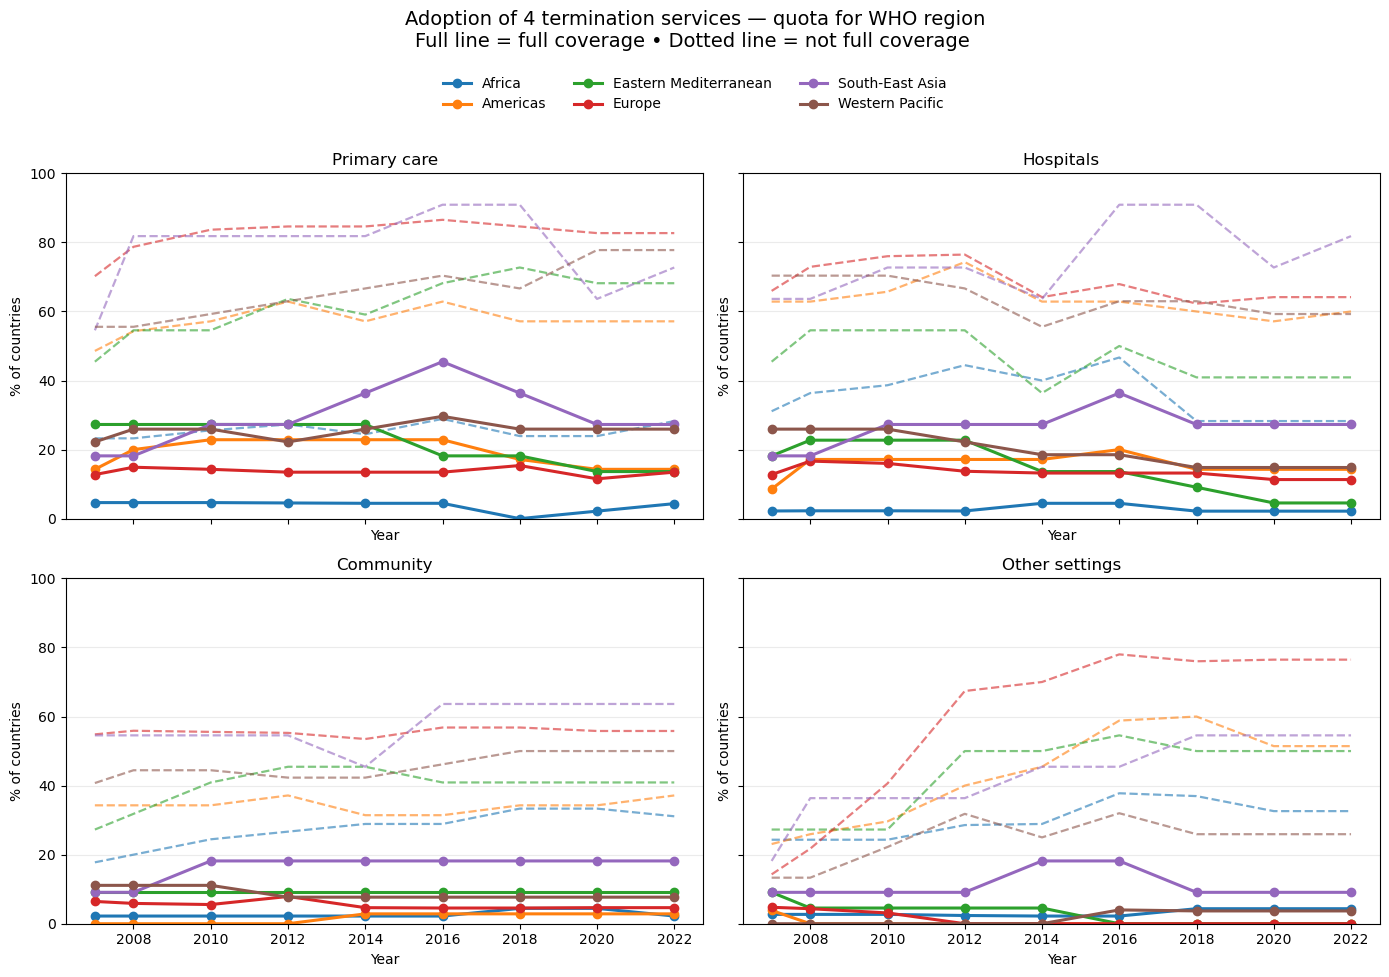

,region,pct_full,pct_any,service,year
0,Africa,4.3,28.3,Primary care,2022
1,Americas,14.3,57.1,Primary care,2022
2,Eastern Mediterranean,13.6,68.2,Primary care,2022
3,Europe,13.5,82.7,Primary care,2022
4,South-East Asia,27.3,72.7,Primary care,2022
5,Western Pacific,25.9,77.8,Primary care,2022
6,Africa,2.2,28.3,Hospitals,2022
7,Americas,14.3,60.0,Hospitals,2022
8,Eastern Mediterranean,4.5,40.9,Hospitals,2022
9,Europe,11.3,64.2,Hospitals,2022


In [10]:
# =========================
# O3c — Trend per Regione OMS dei 4 servizi
# (full = "Yes in most/Yes", any = "Yes in some" o "Yes in most/Yes")
# =========================
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

PROJ = Path.cwd()
DATA_DIRS = [PROJ/"data"/"O", PROJ/"data", PROJ]
OUT_DIR  = PROJ/"lavoro marco"/"O"/"outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def find_file(fname: str) -> Path:
    for d in DATA_DIRS:
        p = d/fname
        if p.exists(): return p
    hits = list(PROJ.rglob(fname))
    if hits: return hits[0]
    raise FileNotFoundError(fname)

SERVICES = {
    "primary_care":  ("Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv",
                      "Primary care"),
    "hospitals":     ("Tobacco_help_smoking_cessation_support_is_available_in_hospitals.csv",
                      "Hospitals"),
    "community":     ("Tobacco_help_smoking_cessation_support_is_available_in_the_community.csv",
                      "Community"),
    "other_settings":("Tobacco_help_smoking_cessation_support_is_available_in_other_settings.csv",
                      "Other settings"),
}

REGION_ORDER = ["Africa","Americas","Eastern Mediterranean","Europe","South-East Asia","Western Pacific"]
PALETTE_REGION = {"Africa":"#1f77b4","Americas":"#ff7f0e","Eastern Mediterranean":"#2ca02c",
                  "Europe":"#d62728","South-East Asia":"#9467bd","Western Pacific":"#8c564b"}

def load_service_ts(csv_path: Path, year_min=2007, year_max=2022) -> pd.DataFrame:
    """Period/ParentLocation/Value -> anno×regione con pct_full e pct_any."""
    d = pd.read_csv(csv_path)
    for c in ["Period","ParentLocation","Value"]:
        if c not in d.columns:
            raise ValueError(f"Nel file {csv_path.name} manca {c}")

    # anno
    d["year"] = pd.to_numeric(d["Period"].astype(str).str.extract(r"(\d{4})")[0], errors="coerce").astype("Int64")
    d = d[d["year"].between(year_min, year_max, inclusive="both")]

    # classifica
    def classify(v: str) -> str:
        if pd.isna(v): return "na"
        t = str(v).strip().lower()
        if t in {"missing value", ""}: return "na"
        if t == "no" or " not " in f" {t} " or "unavailable" in t or "illegal" in t:
            return "no"
        if "most" in t or t == "yes":
            return "full"
        if "some" in t or "partial" in t:
            return "partial"
        return "na"

    d["class"]  = d["Value"].map(classify)
    d["region"] = d["ParentLocation"]

    # aggrega anno×regione
    g = (d.groupby(["year","region"])
           .agg(n=("class", lambda s: (s!="na").sum()),
                full=("class", lambda s: (s=="full").sum()),
                anyc=("class",  lambda s: ((s=="full") | (s=="partial")).sum()))
           .reset_index())
    g["pct_full"] = np.where(g["n"]>0, 100*g["full"]/g["n"], np.nan)
    g["pct_any"]  = np.where(g["n"]>0, 100*g["anyc"]/g["n"], np.nan)
    g = g[g["region"].isin(REGION_ORDER)]
    return g

# carica tutte le serie
ts_by_service = {k: load_service_ts(find_file(fname)) for k,(fname,_) in SERVICES.items()}

# plot 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=True)
axes = axes.ravel()
for ax, (key, (fname, nice)) in zip(axes, SERVICES.items()):
    df_ts = ts_by_service[key]
    years = sorted(df_ts["year"].dropna().unique().tolist())
    for reg in REGION_ORDER:
        sub = (df_ts[df_ts["region"]==reg].set_index("year").reindex(years))
        ax.plot(years, sub["pct_full"], linewidth=2.2, marker="o",
                color=PALETTE_REGION[reg], label=reg if key=="primary_care" else None)
        ax.plot(years, sub["pct_any"],  linewidth=1.6, linestyle="--",
                color=PALETTE_REGION[reg], alpha=0.6)
    ax.set_title(nice)
    ax.grid(True, axis="y", alpha=0.25)
    ax.set_ylim(0, 100)
    ax.set_ylabel("% of countries")
    ax.set_xlabel("Year")

# legenda unica
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.02))

fig.suptitle("Adoption of 4 termination services — quota for WHO region\nFull line = full coverage • Dotted line = not full coverage ", fontsize=14, y=1.08)
fig.tight_layout()
fig.savefig(OUT_DIR/"O3c_trend_services_by_region.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT_DIR/"O3c_trend_services_by_region.svg", dpi=300, bbox_inches="tight")
plt.show()

# (facoltativo) tabella riepilogo ultimo anno per commenti
last_rows = []
for key,(fname,nice) in SERVICES.items():
    t = ts_by_service[key]
    ylast = t["year"].max()
    snap = (t[t["year"]==ylast]
            .set_index("region")[["pct_full","pct_any"]]
            .reindex(REGION_ORDER))
    snap["service"] = nice; snap["year"] = ylast
    last_rows.append(snap.reset_index())
summary_last = pd.concat(last_rows, ignore_index=True)
display(summary_last.round(1))


## __Grafico 4__ ## 

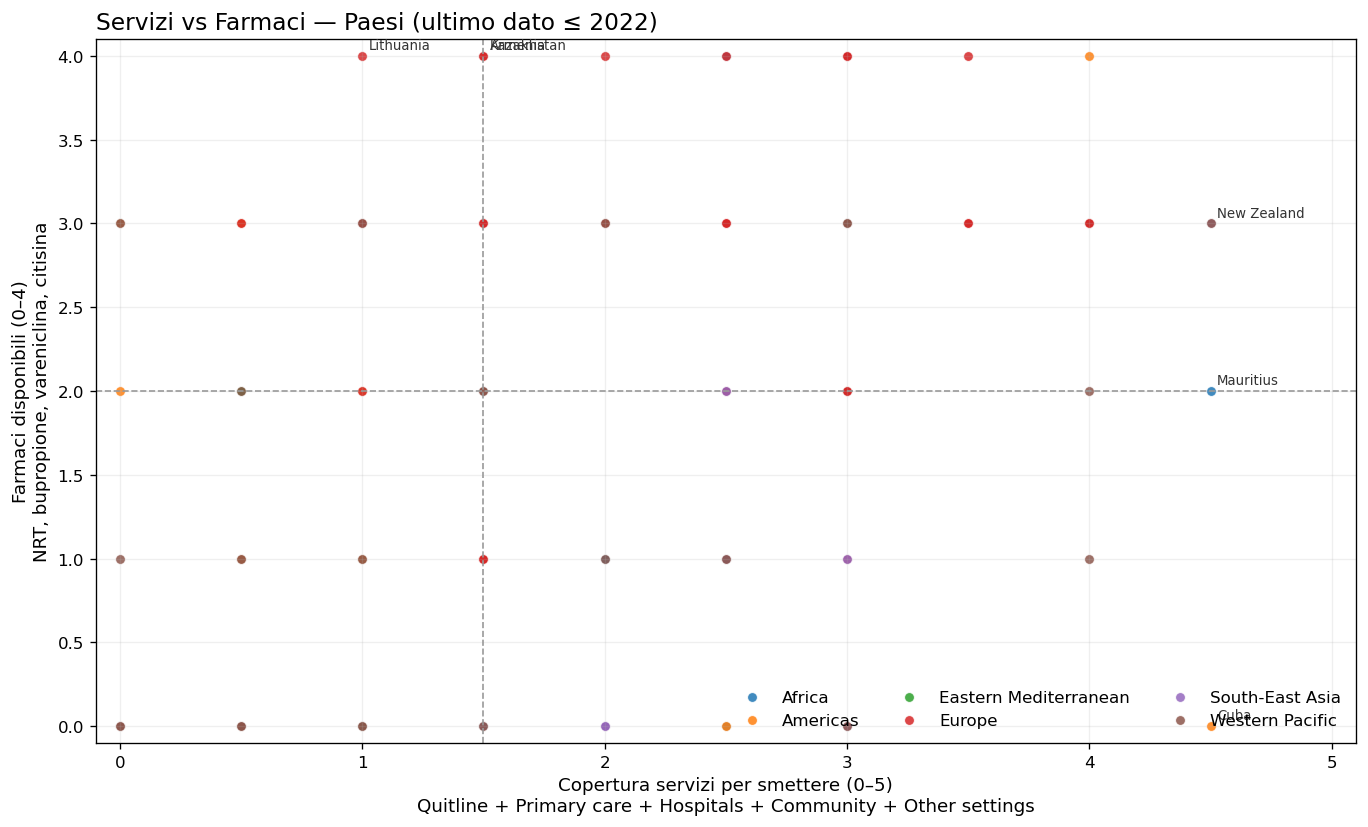

N. paesi plottati: 195
                country  service_score  drugs_count
0           Afghanistan            0.5          0.0
1                Angola            1.0          0.0
2               Albania            0.5          0.0
3               Andorra            0.5          3.0
4  United Arab Emirates            3.0          2.0
5             Argentina            2.5          3.0
6               Armenia            1.5          4.0
7   Antigua and Barbuda            0.0          0.0


In [ ]:
# =========================
# O4 — Scatter "Servizi vs Farmaci" per Paese (ultimo dato ≤ 2022)
# =========================
from pathlib import Path
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

PROJ = Path.cwd()
DATA_DIRS = [PROJ/"data"/"O", PROJ/"data", PROJ]
OUT_DIR  = PROJ/"lavoro marco"/"O"/"outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def find_file(fname: str) -> Path:
    for d in DATA_DIRS:
        p = d/fname
        if p.exists(): return p
    hits = list(PROJ.rglob(fname))
    if hits: return hits[0]
    raise FileNotFoundError(fname)

# *** FORZA i 9 dataset, senza riusare FILES vecchi ***
FILES_9 = {
    "quitline": "Tobacco_control_offer_help_Access_to_a_toll-free_quit_line.csv",
    "primary_care": "Tobacco_help_smoking_cessation_support_is_available_in_health_clinics_or_other_primary_care_facilities.csv",
    "hospitals": "Tobacco_help_smoking_cessation_support_is_available_in_hospitals.csv",
    "community": "Tobacco_help_smoking_cessation_support_is_available_in_the_community.csv",
    "other_settings": "Tobacco_help_smoking_cessation_support_is_available_in_other_settings.csv",
    "nrt": "Tobacco_medication_legally_sold_nicotine_replacement_therapy.csv",
    "bupropion": "Tobacco_medication_legally_sold_Bupropion.csv",
    "varenicline": "Varenicline_-_legally_sold_(Tobacco_control_Offer_help).csv",
    "cytisine": "Tobacco_medication_legally_sold_Cytisine.csv",
}
COMP_KIND_9 = {
    "quitline":"binary","primary_care":"service","hospitals":"service",
    "community":"service","other_settings":"service",
    "nrt":"binary","bupropion":"binary","varenicline":"binary","cytisine":"binary",
}

# standardize + parser (come prima)
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    cl = {c.lower(): c for c in df.columns}
    def pick(*cands):
        for c in cands:
            if c in cl: return cl[c]
            for k,v in cl.items():
                if c in k: return v
        return None
    ren={}
    iso=pick("spatialdimvaluecode","iso3","code","country_code");      ren[iso]="iso3" if iso else None
    loc=pick("location","country","spatialdim","name");                ren[loc]="country" if loc else None
    reg=pick("parentlocation","who_region","region");                  ren[reg]="region" if reg else None
    yr =pick("period","timedim","year","time");                        ren[yr] ="year" if yr else None
    val=pick("value","displayvalue","numericvalue","factvaluenumeric");ren[val]="value_raw" if val else None
    ren={k:v for k,v in ren.items() if k}
    df=df.rename(columns=ren)
    keep=[c for c in ["iso3","country","region","year","value_raw"] if c in df.columns]
    return df[keep].copy()

def classify_value(x, kind):
    if pd.isna(x): return "na"
    t = re.sub(r"[^a-z0-9\s]", " ", str(x).lower())
    t = re.sub(r"\s+"," ", t).strip()
    if t in {"missing value",""}: return "na"
    if re.search(r"\bno\b|\bnot\b|\bnone\b|\bunavailable\b|\billegal\b|\bprohibited\b", t): return "no"
    if kind=="service":
        if re.search(r"\bmost\b", t) or t=="yes": return "full"
        if re.search(r"\bsome\b|partial", t):    return "partial"
        return "na"
    else:
        if re.search(r"\byes\b|available|legally sold|^1$", t): return "full"
        return "na"

def score_value(x, kind):
    return {"full":1.0,"partial":0.5,"no":0.0}.get(classify_value(x, kind), np.nan)

def load_component_latest(name: str, kind: str, year_max=2022) -> pd.DataFrame:
    d = pd.read_csv(find_file(FILES_9[name]))
    d = standardize_columns(d)
    # estrai anno da 'year' (Period)
    d["year"] = pd.to_numeric(d["year"].astype(str).str.extract(r"(\d{4})")[0], errors="coerce").astype("Int64")
    d = d[d["year"].notna() & (d["year"] <= year_max)]
    if d.empty:   # ritorna comunque struttura vuota con chiavi per merge
        return pd.DataFrame(columns=["iso3","country","region","score","class"])
    idx = d.groupby("iso3")["year"].transform("max") == d["year"]
    d = d[idx].drop_duplicates("iso3", keep="last")
    d["score"] = d["value_raw"].map(lambda v: score_value(v, kind))
    d["class"]  = d["value_raw"].map(lambda v: classify_value(v, kind))
    return d[["iso3","country","region","score","class"]].copy()

# carica TUTTE le 9 componenti
parts = {k: load_component_latest(k, COMP_KIND_9[k], 2022) for k in FILES_9}

# merge
df_sc = None
for k, d in parts.items():
    d = d.rename(columns={"score": f"{k}_score", "class": f"{k}_class"})
    df_sc = d if df_sc is None else df_sc.merge(d, on=["iso3","country","region"], how="outer")

# punteggi servizi e farmaci (crea colonne mancanti se necessario)
service_cols = ["quitline_score","primary_care_score","hospitals_score","community_score","other_settings_score"]
drug_cols    = ["nrt_score","bupropion_score","varenicline_score","cytisine_score"]
df_sc["service_score"] = df_sc.reindex(columns=service_cols).sum(axis=1, skipna=True)   # 0..5
df_sc["drugs_count"]   = df_sc.reindex(columns=drug_cols).fillna(0).sum(axis=1)         # 0..4

# colori per regione
REGION_MAP = {
    "African Region":"Africa","African":"Africa",
    "Region of the Americas":"Americas","Americas":"Americas",
    "Eastern Mediterranean Region":"Eastern Mediterranean","Eastern Mediterranean":"Eastern Mediterranean",
    "European Region":"Europe","European":"Europe",
    "South-East Asia Region":"South-East Asia","South-East Asia":"South-East Asia",
    "Western Pacific Region":"Western Pacific","Western Pacific":"Western Pacific",
}
df_sc["region_nice"] = df_sc["region"].map(lambda x: REGION_MAP.get(x, x))
PALETTE = {"Africa":"#1f77b4","Americas":"#ff7f0e","Eastern Mediterranean":"#2ca02c",
           "Europe":"#d62728","South-East Asia":"#9467bd","Western Pacific":"#8c564b"}

# filtra e sostituisci NaN con 0 per il plotting
plot_df = df_sc.dropna(subset=["service_score","drugs_count"], how="all").copy()
plot_df["service_score"] = plot_df["service_score"].fillna(0)
plot_df["drugs_count"]   = plot_df["drugs_count"].fillna(0)

# mediane per i quadranti
mx = plot_df["service_score"].median()
my = plot_df["drugs_count"].median()

# scatter
fig, ax = plt.subplots(figsize=(11.5,7))
for reg, sub in plot_df.groupby("region_nice"):
    ax.scatter(sub["service_score"], sub["drugs_count"],
               label=reg, s=35, alpha=0.85, edgecolor="white", linewidth=0.6,
               color=PALETTE.get(reg, "#777"))
ax.axvline(mx, color="#999", ls="--", lw=1)
ax.axhline(my, color="#999", ls="--", lw=1)
ax.set_xlim(-0.1, 5.1); ax.set_ylim(-0.1, 4.1)
ax.set_xlabel("Copertura servizi per smettere (0–5)\nQuitline + Primary care + Hospitals + Community + Other settings")
ax.set_ylabel("Farmaci disponibili (0–4)\nNRT, bupropione, vareniclina, citisina")
ax.set_title("Servizi vs Farmaci — Paesi (ultimo dato ≤ 2022)", loc="left", fontsize=14)
ax.grid(True, alpha=0.2)
ax.legend(ncol=3, frameon=False, loc="lower right")

# etichetta alcuni outlier (mismatch)
def annotate_outliers(df, k=3):
    hi_serv_low_drug = df.sort_values(["service_score","drugs_count"], ascending=[False, True]).head(k)
    hi_drug_low_serv = df.sort_values(["drugs_count","service_score"], ascending=[False, True]).head(k)
    outs = pd.concat([hi_serv_low_drug, hi_drug_low_serv]).drop_duplicates("iso3")
    for _, r in outs.iterrows():
        ax.annotate(r["country"], (r["service_score"], r["drugs_count"]),
                    textcoords="offset points", xytext=(4,4), fontsize=8, color="#333")
annotate_outliers(plot_df, k=3)

fig.tight_layout()
fig.savefig(OUT_DIR/"O4_scatter_services_vs_drugs.png", dpi=300, bbox_inches="tight")
fig.savefig(OUT_DIR/"O4_scatter_services_vs_drugs.svg", dpi=300, bbox_inches="tight")
plt.show()

# debug veloce (puoi cancellare dopo)
print("N. paesi plottati:", len(plot_df))
print(plot_df[["country","service_score","drugs_count"]].head(8))
